# TF-IDF + Multiple classifiers

In this notebook we will try to get the embeddings of the texts of IMDB dataset and then use a specific classification technique to classify these reviews into their corresponding sentiment i.e ***Negative*** or ***Positive***.

In [36]:
from tqdm.notebook import tqdm
import pandas as pd
tqdm.pandas()
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import string
from nltk.corpus import stopwords
import xgboost as xgb
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.linear_model import LogisticRegression
sw=set(stopwords.words('english'))
snow=SnowballStemmer('english')
from sklearn import metrics
from sklearn import model_selection
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
sns.set(rc={'axes.facecolor':'#FAF7CC',"axes.edgecolor":"black","axes.grid":False,"axes.labelsize":30,"xtick.labelsize":15,"ytick.labelsize":15})

[nltk_data] Downloading package stopwords to /home/dhiab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("./data/IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


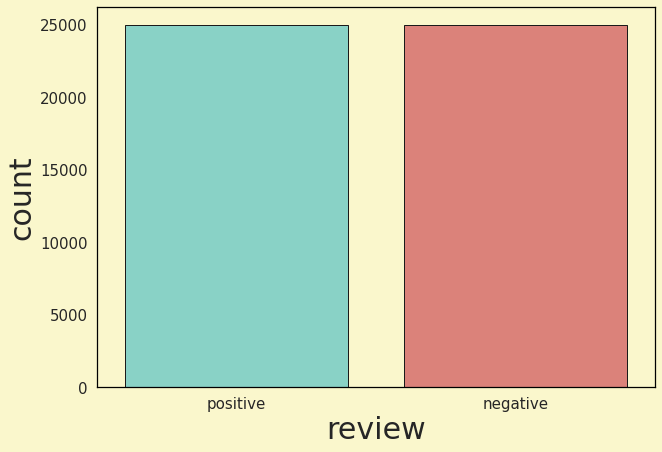

In [3]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
sns.countplot(x="sentiment",data=df,palette=["#7DDECE", "#EB746A"],edgecolor="k")
plt.xlabel('review')
plt.show()

In [4]:
#clean text
def clean_text(text):
    #Removing html tags
    soup=BeautifulSoup(text)
    text=soup.get_text()
    #lowercase every letter
    text=text.lower()
    text = text.split() #split by all white spaces
    
    #join tokens by single space, this will remove all kinds of weird spaces
    text = " ".join(text)
    #removes all punctuation using regex and string module
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    text=' '.join([snow.stem(word) for word in text.split() if word not in sw])
    
    return text
df_new=df.copy()
df_new['review'] = df["review"].progress_apply(clean_text)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [5]:
n=np.random.randint(0,len(df),size=1)[0]
print(f'A review example before performing cleaning:\n\n{df.review.iloc[n]}')
print('-'*50)
print(f'A review example after performing cleaning:\n\n{df_new.review.iloc[n]}')

A review example before performing cleaning:

- The Best Bit : When the dull mobster (Nicholas Turturro) calls out to the runaway (Matthew Modine) "Shane !.. Come Back Shane !" and when the older wise guy asks him "What Are You Doing ?!" he replays simply "Enjoying My Time !" Actually like me at the moment ! <br /><br />- The Most Creepy Part : I've been wondering all the time of watching : where did I see that girl before ? where ? where ? Till I found out while the closing credits.. OHH MY GOD ! She's (Elizabeth Berkley) .. From the showgirls' fiasco ! But I just couldn't recognize her with her clothes on ! To tell you the truth I felt a brief tremor. She's really cute and nice but maybe Hollywood had no mercy at all ! <br /><br />- The Most Sexy Bit : When (Berkley) says "Do You Mean The Stuff Which Gives You A Boner ?!". <br /><br />- The Most Dull Thing : The retarded assistant after a day and a night in the back of the car is still alive and healthy at the end !!??, moreover the 

In [6]:
df_new['sentiment'] = df_new['sentiment'].progress_apply(lambda x: 1 if x=='positive' else 0)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [7]:
# Generate a word cloud image for positive reviews
mask=np.array(Image.open("./data/positive.jpg"))
mask=np.where(mask>230,255,mask)
pos_text=" ".join(review for review in df_new[df_new["sentiment"]==1].review)
wordcloud_pos = WordCloud( mode="RGBA", max_words=1000,mask=mask,background_color="white").generate(pos_text)
image_colors = ImageColorGenerator(mask);
res=wordcloud_pos.recolor(color_func=image_colors)

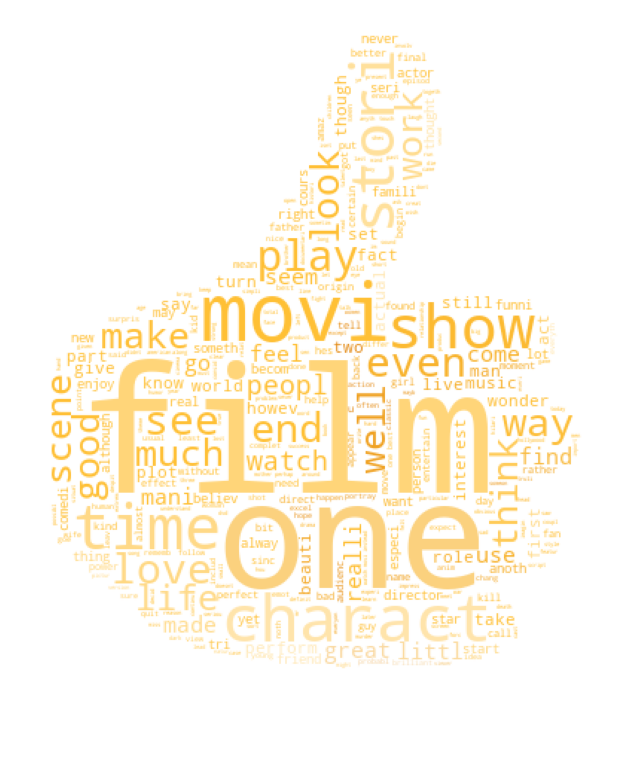

In [8]:
plt.figure(figsize=[14,14])
plt.imshow(res, interpolation="kaiser");
plt.axis("off")
plt.savefig('positive_cloud.png')
plt.show()

In [9]:
# Generate a word cloud image for negative reviews
mask = np.array(Image.open("./data/negative.png"))
mask=np.where(mask>230,255,mask)
neg_text=" ".join(review for review in df_new[df_new["sentiment"]==0].review)
wordcloud_neg = WordCloud( mode="RGBA", max_words=10000, mask=mask,background_color="white").generate(neg_text)
image_colors = ImageColorGenerator(mask);
res_neg=wordcloud_neg.recolor(color_func=image_colors)

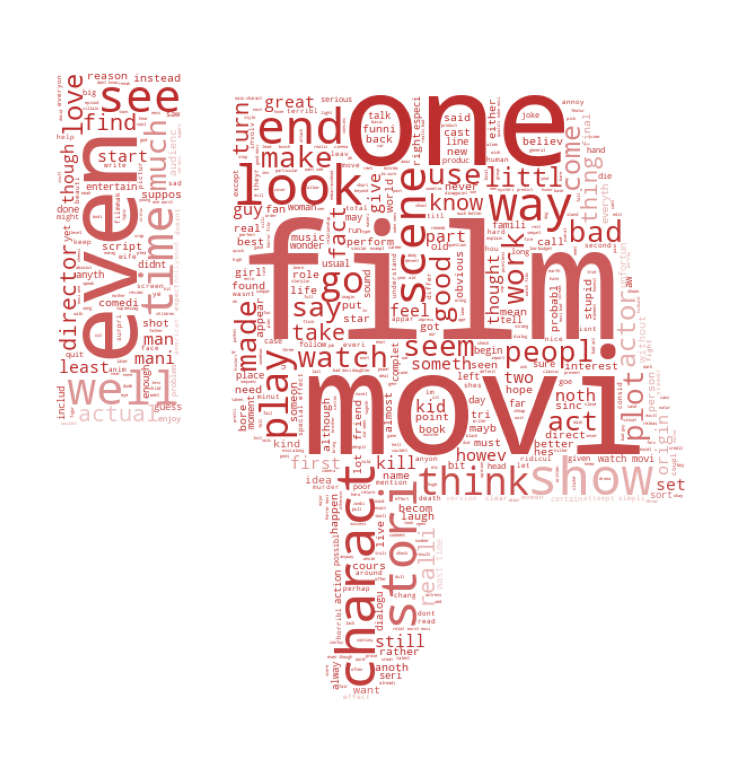

In [10]:
plt.figure(figsize=[14,14])
plt.imshow(res_neg, interpolation="kaiser");
plt.axis("off")
plt.savefig("negative_cloud.png")
plt.show()

# ***Logistic Regressor CLassifier*** :

In [32]:
x_train,x_test,y_train,y_test = train_test_split(df_new['review'], df_new.sentiment, test_size=0.2, random_state=40)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))



accuracy: 88.78%


In [33]:
print(confusion_matrix(y_test, prediction))

[[4478  622]
 [ 500 4400]]


In [34]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5100
           1       0.88      0.90      0.89      4900

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [42]:
train_sizes, train_scores, test_scores=learning_curve(pipe,x_train,y_train,train_sizes=np.linspace(0.1, 1.0, 5))

/home/dhiab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


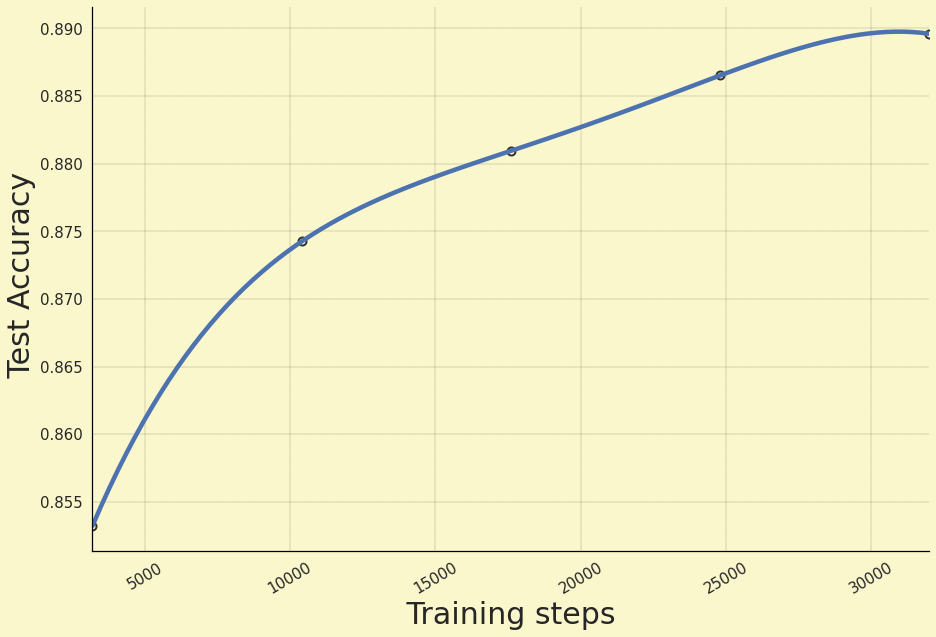

In [127]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (15, 10),facecolor='#FAF7CC')
sns.set(rc={'axes.facecolor':'#FAF7CC',"axes.edgecolor":"black","lines.markersize":8,"lines.linewidth":3,"grid.color":"black","grid.linewidth":0.2,"grid.linestyle":"--","axes.grid":True,"axes.labelsize":30,"xtick.labelsize":15,"ytick.labelsize":15})
sns.regplot(x=train_sizes,y=test_scores.mean(axis=1),order=4,scatter_kws = {'facecolors':'white','color':'black','linewidth':2},ci=None)
sns.despine()
plt.xlabel(' Training steps ')
plt.ylabel(' Test Accuracy')
plt.xticks(rotation=30)
plt.savefig('test_acc.png')
plt.show()

# ***SVM CLassifier*** :

In [14]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 88.95%


# ***Gradient Boosting Classifier*** :

In [15]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 10,
                                                   random_state=55))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 73.48%


# ***XGBoost Classifier*** :

In [25]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(loss = 'deviance',
                                                   learning_rate = 0.5,
                                                   n_estimators = 10,
                                                   max_depth = 30,
                                                   random_state=40))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

/home/dhiab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:55] WARNING: ../src/learner.cc:573: 
Parameters: { "loss" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:29:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 80.93%


# ***Random Forest Classifier*** :

In [28]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 84.63%


# ***Decision Tree CLassifier*** :

In [30]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 50, 
                                           splitter='best', 
                                           random_state=40))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 72.62%
